Observation space: Box(0, 255, (210, 160, 3), uint8)
Action space: Discrete(6)
Number of possible actions: 6
Episode 1: Total Reward = -21.0
Episode 2: Total Reward = -19.0
Episode 3: Total Reward = -17.0
Episode 4: Total Reward = -21.0
Episode 5: Total Reward = -21.0

Average total reward over 3 random episodes: -19.8


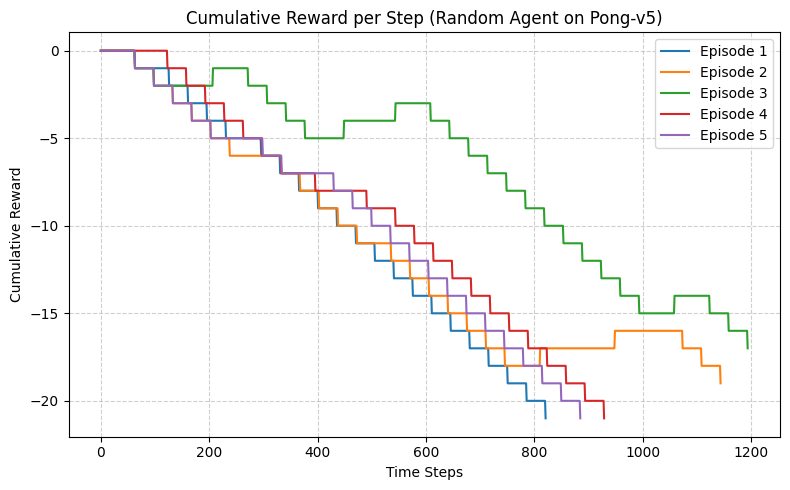

In [ ]:
import gymnasium as gym
import ale_py
import numpy as np
import matplotlib.pyplot as plt

env = gym.make("ALE/Pong-v5", render_mode=None)  # set render_mode='human' if you want to see the game

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Number of possible actions:", env.action_space.n)

num_episodes = 5
episode_rewards = []
reward_trajectories = []  # store reward progression per episode

for ep in range(num_episodes):
    obs, info = env.reset(seed=ep)
    done = False
    total_reward = 0
    rewards = []

    while not done:
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        rewards.append(total_reward)  # cumulative reward curve
        done = terminated or truncated

    episode_rewards.append(total_reward)
    reward_trajectories.append(rewards)
    print(f"Episode {ep+1}: Total Reward = {total_reward}")

env.close()


print(f"\nAverage total reward over {num_episodes} random episodes:", np.mean(episode_rewards))

plt.figure(figsize=(8, 5))
for i, rewards in enumerate(reward_trajectories):
    plt.plot(rewards, label=f'Episode {i+1}')
plt.title("Cumulative Reward per Step (Random Agent on Pong-v5)")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig(f"pong_{num_episodes}_random_agent_rewards.png")
plt.show()


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import ale_py
from collections import deque
import random
import matplotlib.pyplot as plt
import cv2

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Hyperparameters (from DQN paper)
LEARNING_RATE = 0.0001
GAMMA = 0.99  # Discount factor
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 1000000  # Steps over which to decay epsilon
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 1000000  # Original paper uses 1M (100K for quick testing)
TARGET_UPDATE_FREQ = 10000  # Update target network every N steps
FRAME_STACK = 4  # Stack 4 frames as per paper
LEARNING_STARTS = 50000  # Start learning after N steps (can use 10000 for faster start)
SAVE_FREQ = 250000  # Save model every N steps
TOTAL_TRAINING_STEPS = 4000000  # Train for 5M steps for full convergence (10M for paper baseline)

# Frame preprocessing parameters
FRAME_WIDTH = 84
FRAME_HEIGHT = 84


class FramePreprocessor:

    def __init__(self, width=84, height=84):
        self.width = width
        self.height = height
        
    def process(self, frame):
        # Convert to grayscale
        if len(frame.shape) == 3:
            gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        else:
            gray = frame
            
        # Resize to 84x84
        resized = cv2.resize(gray, (self.width, self.height),
                           interpolation=cv2.INTER_AREA)
        
        # Normalize to [0, 1]
        normalized = resized.astype(np.float32) / 255.0
        
        return normalized


class FrameStack: 

    def __init__(self, num_frames=4):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
        
    def reset(self, frame):
        for _ in range(self.num_frames):
            self.frames.append(frame)
        return self.get_state()
    
    def update(self, frame):
        self.frames.append(frame)
        return self.get_state()
    
    def get_state(self):
        return np.stack(self.frames, axis=0)


class ReplayBuffer:
    
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states),
            np.array(dones, dtype=np.float32)
        )
    
    def __len__(self):
        return len(self.buffer)


class DQNetwork(nn.Module):
    
    def __init__(self, num_actions, frame_stack=4):
        super(DQNetwork, self).__init__()
        
        # Convolutional layers as per DQN paper
        self.conv1 = nn.Conv2d(frame_stack, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Calculate size after convolutions
        # Input: 84x84, after conv1: 20x20, after conv2: 9x9, after conv3: 7x7
        conv_output_size = 64 * 7 * 7
        
        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, num_actions)
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


class DQNAgent:
    
    def __init__(self, num_actions, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.num_actions = num_actions
        
        # Q-network and target network
        self.q_network = DQNetwork(num_actions, FRAME_STACK).to(device)
        self.target_network = DQNetwork(num_actions, FRAME_STACK).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        
        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LEARNING_RATE)
        
        # Replay buffer
        self.replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)
        
        # Training stats
        self.steps = 0
        self.epsilon = EPSILON_START
        
    def select_action(self, state, training=True):
        """Select action using epsilon-greedy policy"""
        if training and random.random() < self.epsilon:
            return random.randrange(self.num_actions)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.q_network(state_tensor)
            return q_values.argmax(1).item()
    
    def update_epsilon(self):
        """Decay epsilon"""
        self.epsilon = max(
            EPSILON_END,
            EPSILON_START - (EPSILON_START - EPSILON_END) * self.steps / EPSILON_DECAY
        )
    
    def train_step(self):
        """Perform one training step"""
        if len(self.replay_buffer) < BATCH_SIZE:
            return None
        
        # Sample from replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(BATCH_SIZE)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        
        # Compute Q(s, a)
        q_values = self.q_network(states)
        q_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q values
        with torch.no_grad():
            next_q_values = self.target_network(next_states)
            max_next_q_values = next_q_values.max(1)[0]
            target_q_values = rewards + (1 - dones) * GAMMA * max_next_q_values
        
        # Compute loss (Huber loss for stability)
        loss = nn.SmoothL1Loss()(q_values, target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping as per paper
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 10)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def save_checkpoint(self, filepath, step):
        """Save model checkpoint"""
        torch.save({
            'step': step,
            'q_network_state_dict': self.q_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'epsilon': self.epsilon,
        }, filepath)
    
    def load_checkpoint(self, filepath):
        """Load model checkpoint"""
        checkpoint = torch.load(filepath, map_location=self.device)
        self.q_network.load_state_dict(checkpoint['q_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.epsilon = checkpoint['epsilon']
        self.steps = checkpoint['step']
        return checkpoint['step']


def train_dqn(total_steps=4000000, max_steps_per_episode=10000, save_model=True):
    
    # Initialize environment
    env = gym.make('ALE/Pong-v5', render_mode=None)
    
    # Get action space size
    num_actions = env.action_space.n
    
    # Initialize components
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    agent = DQNAgent(num_actions, device)
    
    # Check for existing checkpoint
    checkpoint_path = 'dqn_pong_step_.pth'
    if os.path.exists(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        global_step = agent.load_checkpoint(checkpoint_path)
        print(f"Resuming training from step {global_step:,}")
    else:
        print("No checkpoint found. Starting training from scratch.")
        global_step = 0
        
    preprocessor = FramePreprocessor(FRAME_WIDTH, FRAME_HEIGHT)
    frame_stack = FrameStack(FRAME_STACK)
    # Training metrics
    episode_rewards = []
    episode_lengths = []
    losses = []
    mean_rewards = []
    best_mean_reward = -float('inf')
    episode = 0

    print("\t\t...Starting training...")
    print(f"Total training steps: {total_steps:,}")
    print(f"Learning starts at step: {LEARNING_STARTS:,}")
    print(f"Epsilon decay over: {EPSILON_DECAY:,} steps")
    print(f"Target network update frequency: {TARGET_UPDATE_FREQ:,} steps")
    print(f"Replay buffer size: {REPLAY_BUFFER_SIZE:,}\n")
    
    # Training loop - continue until we reach total steps
    while global_step < total_steps:
        # Reset environment
        obs, info = env.reset()
        processed_frame = preprocessor.process(obs)
        state = frame_stack.reset(processed_frame)
        
        episode_reward = 0
        episode_loss = []
        
        for step in range(max_steps_per_episode):
            # Select action
            action = agent.select_action(state, training=True)
            
            # Take action in environment
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Preprocess next frame
            processed_next_frame = preprocessor.process(next_obs)
            next_state = frame_stack.update(processed_next_frame)
            
            # Clip reward as per DQN paper
            clipped_reward = np.clip(reward, -1, 1)
            
            # Store transition in replay buffer
            agent.replay_buffer.push(state, action, clipped_reward, next_state, done)
            
            state = next_state
            episode_reward += reward
            global_step += 1
            agent.steps = global_step
            
            # Update epsilon
            agent.update_epsilon()
            
            # Train agent
            if global_step >= LEARNING_STARTS:
                loss = agent.train_step()
                if loss is not None:
                    episode_loss.append(loss)
                
                # Update target network
                if global_step % TARGET_UPDATE_FREQ == 0:
                    agent.update_target_network()
                    print(f"---> Updated target network at step {global_step:,}")
                
                # Save model checkpoint
                if save_model and global_step % SAVE_FREQ == 0:
                    checkpoint_path = f'dqn_pong_step_.pth'
                    agent.save_checkpoint(checkpoint_path, global_step)
                    print(f"---> Model saved: {checkpoint_path}")
            
            if done:
                break
        
        # Record metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(step + 1)
        if episode_loss:
            losses.append(np.mean(episode_loss))
        
        episode += 1
        
        # Calculate moving average (last 100 episodes)
        if len(episode_rewards) >= 100:
            mean_reward = np.mean(episode_rewards[-100:])
            mean_rewards.append(mean_reward)
            
            if mean_reward > best_mean_reward:
                best_mean_reward = mean_reward
        
        # Print progress every 10 episodes
        if episode % 10 == 0:
            avg_reward = np.mean(episode_rewards[-10:]) if episode_rewards else 0
            avg_loss = np.mean(losses[-10:]) if losses else 0
            progress_pct = (global_step / total_steps) * 100
            
            print(f"Episode {episode} | Step {global_step:,}/{total_steps:,} ({progress_pct:.1f}%) | "
                  f"Avg Reward (10 ep): {avg_reward:.2f} | "
                  f"epsilon: {agent.epsilon:.3f} | "
                  f"Loss (10 ep): {avg_loss:.4f}")
            
            if len(episode_rewards) >= 100:
                print(f"---> Mean Reward (100 ep): {mean_rewards[-1]:.2f} | "
                      f"Best Mean: {best_mean_reward:.2f}")
    
    env.close()
    
    # Save final model
    if save_model:
        final_path = 'dqn_pong_final.pth'
        agent.save_checkpoint(final_path, global_step)
        print(f"\n Final model saved: {final_path}")
    
    return {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'losses': losses,
        'mean_rewards': mean_rewards,
        'best_mean_reward': best_mean_reward,
        'agent': agent,
        'total_steps': global_step
    }


def plot_learning_curves(results, n_episodes=100):
    """Plot learning curves"""
    
    episode_rewards = results['episode_rewards']
    mean_rewards = results['mean_rewards']
    best_mean_reward = results['best_mean_reward']
    
    # Calculate cumulative steps for x-axis
    # Approximate steps per episode (varies, but we'll use a running sum)
    steps_per_episode = []
    cumulative_steps = 0
    
    # Estimate steps (rough approximation for plotting)
    for i in range(len(episode_rewards)):
        # Early episodes might be longer, later ones shorter as agent improves
        estimated_steps = 1000  # Average estimate
        cumulative_steps += estimated_steps
        steps_per_episode.append(cumulative_steps)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Episode rewards and mean rewards
    ax1 = axes[0]
    
    # Plot individual episode rewards (lighter)
    ax1.plot(steps_per_episode, episode_rewards, color='deepskyblue', label='Episode Reward')
    
    # Plot mean n-episode rewards
    if mean_rewards:
        mean_steps = steps_per_episode[n_episodes - 1:]
        ax1.plot(mean_steps, mean_rewards, color='red', linewidth=1,
                label=f'Mean {n_episodes}-Episode Reward')
        
        # Plot best mean reward line
        ax1.axhline(y=best_mean_reward, color='green', linestyle='--',
                   linewidth=2, label=f'Best Mean Reward: {best_mean_reward:.2f}')
    
    ax1.set_xlabel('Time Steps (x 1000)', fontsize=12)
    ax1.set_ylabel('Reward', fontsize=12)
    ax1.set_title('DQN Training Performance on Pong-v5', fontsize=14)
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # Format x-axis to show in thousands
    ax1.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    
    # Plot 2: Training loss
    ax2 = axes[1]
    if results['losses']:
        loss_steps = np.linspace(0, steps_per_episode[-1], len(results['losses']))
        ax2.plot(loss_steps, results['losses'], alpha=0.6, color='orange')
        ax2.set_xlabel('Time Steps (x 1000)', fontsize=12)
        ax2.set_ylabel('Loss', fontsize=12)
        ax2.set_title('Training Loss', fontsize=14)
        ax2.grid(True, alpha=0.3)
        ax2.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
    
    plt.tight_layout()
    plt.savefig('dqn_pong_learning_curves.png', dpi=300, bbox_inches='tight')
    print("\nLearning curves saved as 'dqn_pong_learning_curves.png'")


def evaluate_agent(agent, num_episodes=10):
    env = gym.make('ALE/Pong-v5', render_mode=None)
    preprocessor = FramePreprocessor(FRAME_WIDTH, FRAME_HEIGHT)
    frame_stack = FrameStack(FRAME_STACK)

    eval_rewards = []

    # Ensure evaluation log file exists and write header
    log_path = 'evaluation.txt'
    try:
        with open(log_path, 'a') as logf:
            logf.write("\n")
    except Exception:
        print(f"Warning: could not open {log_path} for writing evaluation logs.")

    for episode in range(num_episodes):
        obs, info = env.reset()
        processed_frame = preprocessor.process(obs)
        state = frame_stack.reset(processed_frame)

        episode_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, training=False)
            next_obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            processed_next_frame = preprocessor.process(next_obs)
            state = frame_stack.update(processed_next_frame)

            episode_reward += reward

        eval_rewards.append(episode_reward)
        line = f"Evaluation Episode {episode + 1}/{num_episodes}: Reward = {episode_reward}\n"
        print(line.strip())
        try:
            with open(log_path, 'a') as logf:
                logf.write(line)
        except Exception:
            pass

    env.close()

    mean_eval_reward = np.mean(eval_rewards)
    mean_line = f"Mean Evaluation Reward: {mean_eval_reward:.2f}\n"
    print(f"\n{mean_line.strip()}")
    try:
        with open(log_path, 'a') as logf:
            logf.write(mean_line + "\n")
    except Exception:
        pass

    return eval_rewards


if __name__ == "__main__":
    training_steps = 2500000
    
    print(f"\nStarting training with {training_steps:,} steps...")
    
    # Train agent
    results = train_dqn(total_steps=training_steps, max_steps_per_episode=10000)
    print(" Training Complete!")
    print(f"Best Mean Reward (100 ep): {results['best_mean_reward']:.2f}")
    print(f"Total Episodes: {len(results['episode_rewards'])}")
    
    # Save results to a .npz file
    np.savez('dqn_pong_results.npz',
             episode_rewards=results['episode_rewards'],
             episode_lengths=results['episode_lengths'],
             losses=results['losses'],
             mean_rewards=results['mean_rewards'],
             best_mean_reward=results['best_mean_reward'],
             total_steps=results['total_steps'])
    print("\nResults saved to 'dqn_pong_results.npz'")
    
    # Plot learning curves
    plot_learning_curves(results, n_episodes=100)
    
    # Evaluate agent
    print("\n" + "=" * 70)
    print("Evaluating Trained Agent")
    eval_rewards = evaluate_agent(results['agent'], num_episodes=1000)


# Part(a)

- The random agent just keeps getting worse, losing more and more over both short (5) and longer (15) episodes in Pong-v5. No sign of improvement.

- Flat Rewards with Little Variation: The rewards look predictable and follow a stair-step pattern (since Pong rewards are either -1 or +1 according to atari games documentation). The random agent mostly ends up with negative rewards, and there’s not much change from one episode to the next.

- Mostly Negative Scores: At the end of each episode, the agent’s cumulative score is usually between -15 and -21. $\to$ it’s bad no matter the length of the episode.

---
![5ep Random Agent](part(a)/pong_5_random_agent_rewards.png)
![15ep Random Agent](part(a)/pong_15_random_agent_rewards.png)

<center>Figure-1: Rewards obtained by a random agent in Pong over 5(top) and 15(bottom) episodes.</center>

---

---

# Part(b)

**Note :** 

> The trained DQN had checkpoints saved for every 0.25M steps up to 2.5M steps.  
During the 1st run, the agent was trained for 1M steps and it's performance was plotted as below, where the best mean reward until then was -10.22 for a running average of 100 episodes.

![1Msteps DQN Agent](part(b)/dqn_pong_learning_curves_1M.png)
<center>
Figure 2: Learning curve of DQN agent trained for 1M steps in Pong.  <br>
Avg-return curve(top), Training loss curve(bottom).
</center>

---

> After that, due to computational constraints, the agent had to train for each checkpoint seperately for the next 1.5M steps (i.e from 1M to 2.5M steps). The model weights and training states are stored at [dqn_pong_step_25L.pth](part(b)/dqn_pong_step_25L.pth) and [dqn_pong_final.pth](part(b)/dqn_pong_final.pth) (both are same to be honest).  
The issue here is, the training has been done, but the learning curves could not be recorded because the training for each checkpoint was done seperately and not in a sinlgle run for many steps(like in 1M).  

> So, the model was trained for anothe 0.1M steps(from 2.5M to 2.6M) to get the learning curves as shown below. The best mean reward until then was 7 for a running average for 10 episodes for a total of 40 new episodes. hence the learning curve for this 0.1M steps shown below is only for reference to show the improvement in performance after 2.5M steps.

> To further evaluate the performance of the DQN agent, it was tested for 100 episodes and the rewards obtained are shown in the file [evaluation.txt](part(b)/evaluation.txt). The agent performs significantly better than the random agent, winning most of the episodes with positive rewards.  
The final model results are saved @ [dqn_pong_results.npz](part(b)/dqn_pong_results.npz).

Thus the trainined model performed good and can do better for many more training steps(to 8M to touch max reward almost as close as 21.0) starting from the latest checkpoint(of 2.5M steps)

---

![0.1Msteps DQN Agent](part(b)/dqn_pong_learning_curves_26L.png)
<center>
Figure-3: Learning curve of DQN agent trained for an additional 0.1M steps in Pong(after 2.5M steps).  <br>
Avg-return curve(top), Training loss curve(bottom).
</center>

---

---

# Part(c)

## Unfortunate training contraints couldn't be met for doing part(c) as adviced by sir as well